In [21]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np


In [14]:
def read_file(filename):
    # Regex pattern to match experiment header and time
    header_pattern = r"file_name: (\w+), chunk_size: (\d+), output_len: (\d+)"
    time_pattern = r"Time: (\d+\.\d+)"

    experiments = defaultdict(list)

    # Read file
    with open(filename, 'r') as f:
        lines = f.readlines()

    experiment_key = None
    for line in lines:
        header_match = re.match(header_pattern, line)
        if header_match:
            experiment_key = header_match.groups()
        else:
            time_match = re.match(time_pattern, line)
            if time_match:
                experiments[experiment_key].append(float(time_match.group(1)))

    # Compute averages
    averages = {key: sum(times)/len(times) for key, times in experiments.items()}
    return averages


In [15]:
parrot = read_file('parrot_main.log')
vllm = read_file('fschat_vllm.log')
hf = read_file('fschat_hf.log')

In [16]:
outlens = [25, 50, 75, 100]

In [19]:
print('parrot', parrot)
print('vllm', vllm)
print('hf', hf)

parrot {('article_0', '1024', '25'): 46.5409, ('article_0', '1024', '50'): 85.86026, ('article_0', '1024', '75'): 125.41417999999999, ('article_0', '1024', '100'): 165.06474, ('article_1', '1024', '25'): 29.00204, ('article_1', '1024', '50'): 53.75086, ('article_1', '1024', '75'): 78.49366, ('article_1', '1024', '100'): 103.43696, ('article_2', '1024', '25'): 33.0846, ('article_2', '1024', '50'): 61.1126, ('article_2', '1024', '75'): 89.19862, ('article_2', '1024', '100'): 117.28822, ('article_3', '1024', '25'): 28.12484, ('article_3', '1024', '50'): 52.28207999999999, ('article_3', '1024', '75'): 76.55332000000001, ('article_3', '1024', '100'): 100.88876, ('article_4', '1024', '25'): 38.265499999999996, ('article_4', '1024', '50'): 70.89358, ('article_4', '1024', '75'): 103.59525999999998, ('article_4', '1024', '100'): 136.46804000000003, ('article_5', '1024', '25'): 36.34926, ('article_5', '1024', '50'): 67.32770000000001, ('article_5', '1024', '75'): 98.48053999999999, ('article_5',

In [38]:

output_lengths = ['25', '50', '75', '100']
systems = ['parrot', 'vllm', 'hf']
hatches = ['', '\\', '/']
colors = [
"#d73027",
"#fc8d59",
"#4575b4"]

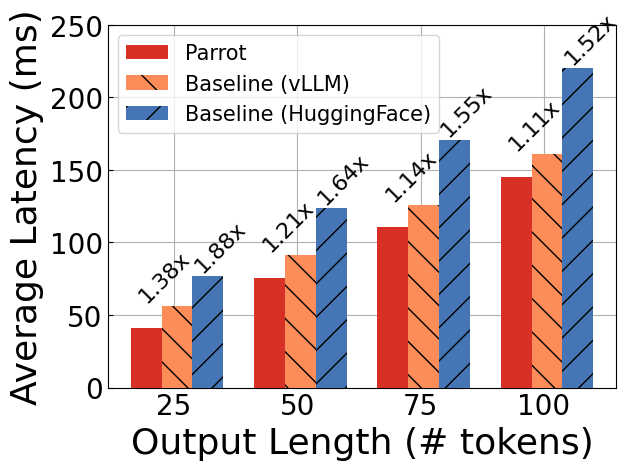

In [82]:
# Organize the data
data = {
    "parrot": parrot,
    "vllm": vllm,
    "hf": hf
}

names = {
    "parrot": "Parrot",
    "vllm": "Baseline (vLLM)",
    "hf": "Baseline (HuggingFace)"
}

statistics = {ol: {s: [] for s in systems} for ol in output_lengths}

for system, system_data in data.items():
    for key, value in system_data.items():
        output_len = key[2]
        statistics[output_len][system].append(value)

# Calculate statistics
averages = {ol: {s: np.mean(values) for s, values in ol_data.items()} for ol, ol_data in statistics.items()}
mins = {ol: {s: np.min(values) for s, values in ol_data.items()} for ol, ol_data in statistics.items()}
maxs = {ol: {s: np.max(values) for s, values in ol_data.items()} for ol, ol_data in statistics.items()}

# Generate the chart
x = np.arange(len(output_lengths))
width = 0.25

fig, ax = plt.subplots()


plt.grid(True)
for i, system in enumerate(systems):
    avg = [averages[ol][system] for ol in output_lengths]
    min_ = [mins[ol][system] for ol in output_lengths]
    max_ = [maxs[ol][system] for ol in output_lengths]
    
    rects = ax.bar(x - width/2 + i*width, avg, width,  hatch = hatches[i], color = colors[i], label=names[system],zorder=3) # hatches
    
    # Add speedup values
    if system != 'parrot':
        speedup_values = [averages[ol][system]/averages[ol]['parrot'] for ol in output_lengths]
        for rect, speedup in zip(rects, speedup_values):
            height = rect.get_height()
            diff = 0.1 if system == 'vllm' else -0.1
            ax.text(rect.get_x() + rect.get_width() / 2 -diff, height,
                    '{:.2f}x'.format(speedup),
                    ha='center', va='bottom', rotation=45,
                    fontsize=16)
            
plt.legend(loc='upper left', prop = { "size": 15 },)
ax.tick_params(axis='y', labelsize=20, direction='in')
ax.tick_params(axis='x', labelsize=20, direction='in')
ax.set_xlabel('Output Length (# tokens)', fontsize=26)
ax.set_ylabel('Average Latency (ms)', fontsize=26)
ax.set_xticks([_+0.1 for _ in x])
ax.set_xticklabels(output_lengths)
plt.ylim([0,250])

fig.tight_layout()

plt.savefig('chain-single-outlen.pdf')

In [42]:
for ol in output_lengths:
    print(ol)
    print(averages[ol]['hf']/averages[ol]['parrot'])
    print(averages[ol]['vllm']/averages[ol]['parrot'])

25
1.8759961098577047
1.3833286156212998
50
1.6379719264214698
1.2054189561852335
75
1.54553536074003
1.140709259859997
100
1.5180108710426727
1.1077330776953116
